In [2]:
%matplotlib inline

# Detecting deforestation using pyCCD

>## Finding a study area  
>I found the following area using google earth and surreptitious comparison with [this](http://www.earthenginepartners.appspot.com/science-2013-global-forest) web-visualization provided by the University of Maryland.  
  
>The image below was generated using google earth. Change occurs on some date between Feb 9 2013, and Feb 23 2014.   
  
> ![img](http://i.imgur.com/KLcdYFN.png)  
  
> The rest of this section focuses on using pyCCD to detect this change.  
  
<br>  
## Extent Declaration
The extents or boundaries of this area are defined in the dictionary below

In [2]:
from datetime import datetime

extents = {
    "deforestation_bangladesh": {
        "longitude": (90.031428,  90.040565), 
        "latitude": ( 25.225266, 25.232605),
        "product" : "ls7_ledaps_bangladesh",
        "platform": "LANDSAT_7",
        "measurements": ['red','green','blue','nir','swir1','swir2','pixel_qa'],
        "time": (datetime(2006,1,1), datetime.max)
    },        
}


## Initialize Datacube and Load Area  

In [3]:
import datacube

dc = datacube.Datacube(app='pyccd_bangladesh', config = "/home/localuser/.datacube.conf")

bangladesh = dc.load(**extents["deforestation_bangladesh"])

## Visualizing Cloud Coverage

`pyCCD` requires a threshold of at least 25% clear coverage(This means that land has to be classified as not-cloudy 75% of the time). The following section quicky outputs a visualization of `clear_percentage` values in the loaded area. This is a step taken to debug/understand our data. 

If you're focused on pyccd I would recommend glancing over the visualization and coming to the conclusion that the amount of `clear pixels` in the area exeeds the minimum threshold, and move on.  
<br>

In [4]:
import numpy as np  

def clear_to_total_ratio(dataset):
    clear_pixels = dataset.pixel_qa == 2 + 64
    water_pixels = dataset.pixel_qa == 4 + 64    
    mask = np.logical_or(clear_pixels, water_pixels).astype(np.int)
    
    return mask.mean(dim = ['time']).rename("clear_cover_percentage")

<br>  

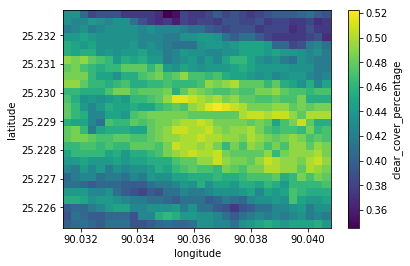

In [5]:
coverage = clear_to_total_ratio(bangladesh)
coverage.where(coverage > 0.25).plot()

## Running pyCCD on a single pixel

The first step in this process would be selecting a pixel to analyze. The following coordinates are derived from analysis of high resolution imagery on Google Earth in an area where deforestation may have happened.  
<br>

In [6]:
pixel_coordinates = {"latitude":25.228928,"longitude": 90.035790}

<br>
The coordinates above aren't exactley aligned with the coordinates of our dataset.  In the code below we select the pixel from our dataset that is closest to our `pixel_coordinates` using [nearest](http://xarray.pydata.org/en/stable/indexing.html#nearest-neighbor-lookups).  
<br>  

In [7]:
pixel = bangladesh.sel(**pixel_coordinates, method = 'nearest')

<br>  

The next step is importing our change detection utility.  
`utils.dc_ccd` is a datacube wrapper for [pyCCD](https://github.com/USGS-EROS/lcmap-pyccd).  
  
<br>

In [8]:
import utils.data_cube_utilities.dc_ccd as ccd

<br>
I process our target pixel using `ccd.process_pixel()`. This function takes a single positional argument: a 1x1 pixel dataset.   
<br>

In [9]:
ccd_proccessed_pixel = ccd.process_pixel(pixel)

DEBUG:ccd.procedures:Procedure selected: standard_procedure
DEBUG:ccd.procedures:Build change models - dates: 136, obs: (7, 136), meow_size: 12, peek_size: 6
DEBUG:ccd.procedures:Processing mask initial count: 67
DEBUG:ccd.procedures:Variogram values: [ 259.  211.  276.  451.  372.  267.    0.]
DEBUG:ccd.procedures:Initialize for change model #: 1
DEBUG:ccd.procedures:Initial slice(0, 12, None)
DEBUG:ccd.procedures:Checking window: slice(0, 12, None)
DEBUG:ccd.procedures:Number of Tmask outliers found: 0
DEBUG:ccd.procedures:Generating models to check for stability
DEBUG:ccd.change:Stability norm: 9.3007396674, Check against: 15.086272469388987
DEBUG:ccd.procedures:Stable start found: slice(0, 12, None)
DEBUG:ccd.procedures:Extend change model
DEBUG:ccd.procedures:lookforward initial model window: slice(0, 12, None)
DEBUG:ccd.procedures:Detecting change for slice(12, 18, None)
DEBUG:ccd.procedures:Retrain models, less than 24 samples
DEBUG:ccd.change:Magnitudes of change: [ 0.88896638 

DEBUG:ccd.procedures:Detecting change for slice(49, 55, None)
DEBUG:ccd.change:Magnitudes of change: [  3.28226049   5.20356204   6.13830366   8.21462121  36.53030935
  71.05157445]
DEBUG:ccd.procedures:Detecting change for slice(50, 56, None)
DEBUG:ccd.change:Magnitudes of change: [  5.19025851   6.13674185   8.21416125  36.37691173  71.05082974
  72.20174885]
DEBUG:ccd.procedures:Detecting change for slice(51, 57, None)
DEBUG:ccd.change:Magnitudes of change: [  6.13893165   8.21480615  36.59198992  71.0518739   72.22870028
  46.56877867]
DEBUG:ccd.procedures:Detecting change for slice(52, 58, None)
DEBUG:ccd.change:Magnitudes of change: [  8.214827    36.59894146  71.05190764  72.22957137  46.57189807
  84.52505301]
DEBUG:ccd.procedures:Detecting change for slice(53, 59, None)
DEBUG:ccd.change:Magnitudes of change: [ 36.8282805   71.05302103  72.25830983  46.67481071  84.73835906
  62.09908937]
DEBUG:ccd.procedures:Change detected at: 53
DEBUG:ccd.procedures:Accumulate results, 1 so 

<br> 

The function above takes our original dataset and appends ccd related attributes to your xarray that can be checked using `xarray.dataset.attrs`.  

<br>

In [10]:
ccd_proccessed_pixel.attrs.keys()

odict_keys(['crs', 'ccd_results', 'ccd_start_times', 'ccd_end_times', 'ccd_break_times', 'ccd'])

<br>

## Plotting pyCCD results  

  
Passing a pixel into the `ccd.plot` function will display time series visualizations depicting change on one or more of the bands.  

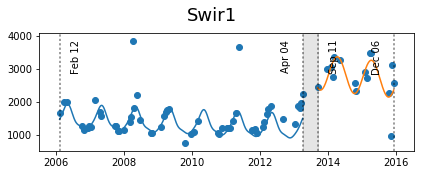

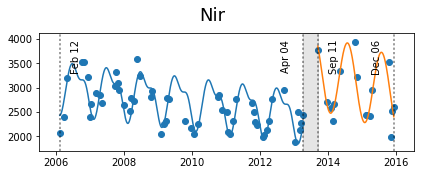

In [11]:
ccd.plot_pixel(ccd_proccessed_pixel, bands = ['swir1', 'nir'])

## Running pyCCD on a large area

The plot pixel function above is suitable for a per-pixel analysis case. The final product stores a large number of coeffiecients per pixel. Detailed below is a closed-form calculation of the number of coefficients needed per pixel.   

<br>

$$ Num_{coefficients} = 8 * Num_{bands} * (Num_{changes} + 1) $$ 

<br>

This sort of growth makes in-memory storage of coefficients infeasible for larger areas.  To combat this, Instead of storing the  coefficients of each pixel, we generate a `change_volume` product.    
  
  <br>

![img](diagrams/ccd/change_volume.png)

The `change_volume` product is the count of all `break_day` indices in a per pixel pyccd analysis.  To compute this, simply call `ccd.process_xarray()`. For for large areas, this should take a considerable amount of time to compute (2 hours for a 300x300 px swath)  
<br>

In [12]:
change_volume_bangladesh = ccd.process_xarray(bangladesh, distributed = True)


`ccd.process_xarray()` should return an xarray data-array detailing change volume. Being an `xarray.dataarray()`, you should be able to call a plot function to visualize results  
  
<br>  


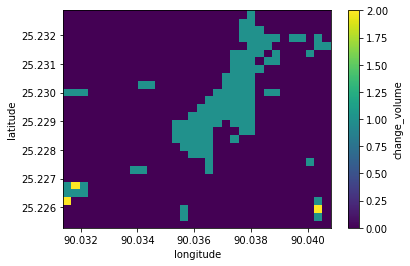

In [13]:
change_volume_bangladesh.plot()

### Comparisons to GE imagery

Visual comparisons of `change_volume` to GE imagery partially confirms accuracy.  


<img src = "http://i.imgur.com/KLcdYFN.png" width = 70% style ="float: left;">

<br>
<br>

# Detecting Urbanization using pyCCD  

This example focuses detecting urbanization in the city of Cartagena del Chairá in Colombia. The code below defines the extent of our case study.  


In [14]:
extents = {
    "urbanization_colombia": {
        "longitude": (-74.86272147522804, -74.82286238285974), 
        "latitude":  (1.326481586145379, 1.356909851914352),
        "product" : "ls7_ledaps_colombia",
        "platform": "LANDSAT_7",
        "measurements": ['red','green','blue','nir','swir1','swir2','pixel_qa'],
    },        
}

### Visualizing the area  
The following code is used to visualize the city of Cartagena del Chairá in Colombia.  

In [15]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = extents["urbanization_colombia"]["latitude"], longitude = extents["urbanization_colombia"]["longitude"])

>### Load  data from Datacube 

In [16]:
landsat_cartagena = dc.load(**extents['urbanization_colombia'])  

> ### Process Data using CCD  

In [17]:
change_volume_cartagena = ccd.process_xarray(landsat_cartagena, distributed = True)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordin

> ### Display change

The change below reflects development in the bottom right quadrant of the city.   

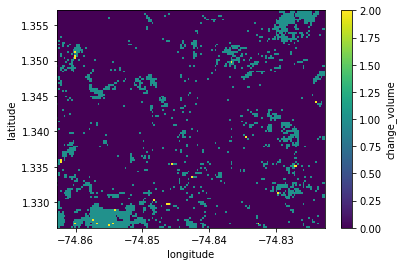

In [18]:
change_volume_cartagena.plot()

The two plots below serve as validation of these results by providing a visualizaiton of *pre* and *post* acquisitions.  
  
<br>  

>### Acquisition in 2000

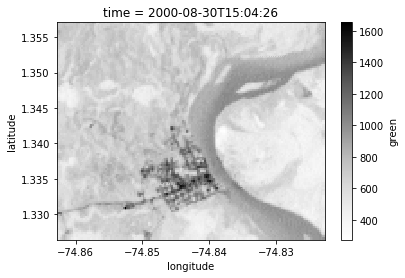

In [19]:
early_acquisition = landsat_cartagena.isel(time = 5)

early_acquisition.green.plot(cmap = 'Greys')

>### Acquisition in 2012

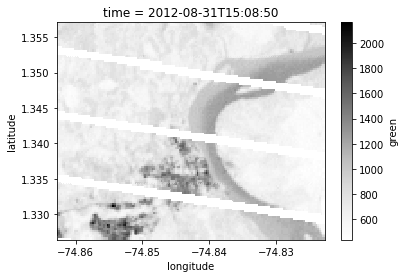

In [20]:
late_acquisition = landsat_cartagena.isel(time = 124)

late_acquisition.where(late_acquisition > 0).green.plot(cmap = 'Greys')

> ### Analyze Pixel In Change Area  
> The results above highlight change in the south-western region of the city. The following section focuses on the analyses of a single pixel in that area.  
  

In [21]:
target_point =  {"latitude": 1.3282, "longitude": -74.8549}
target_pixel = landsat_cartagena.sel(**target_point, method = "nearest")

<br>  

In [22]:
processed_pixel = ccd.process_pixel(target_pixel)  

DEBUG:ccd.procedures:Procedure selected: standard_procedure
DEBUG:ccd.procedures:Build change models - dates: 152, obs: (7, 152), meow_size: 12, peek_size: 6
DEBUG:ccd.procedures:Processing mask initial count: 62
DEBUG:ccd.procedures:Variogram values: [ 224.   201.5  261.5  435.5  503.   334.5    0. ]
DEBUG:ccd.procedures:Initialize for change model #: 1
DEBUG:ccd.procedures:Initial slice(0, 12, None)
DEBUG:ccd.procedures:Checking window: slice(0, 12, None)
DEBUG:ccd.procedures:Number of Tmask outliers found: 0
DEBUG:ccd.procedures:Generating models to check for stability
DEBUG:ccd.change:Stability norm: 22.1957401693, Check against: 15.086272469388987
DEBUG:ccd.procedures:Unstable model, shift window to: slice(1, 13, None)
DEBUG:ccd.procedures:Checking window: slice(1, 13, None)
DEBUG:ccd.procedures:Number of Tmask outliers found: 0
DEBUG:ccd.procedures:Generating models to check for stability
DEBUG:ccd.change:Stability norm: 31.9965992804, Check against: 15.086272469388987
DEBUG:ccd.

DEBUG:ccd.procedures:Detecting change for slice(48, 54, None)
DEBUG:ccd.procedures:Retrain models, less than 24 samples
DEBUG:ccd.change:Magnitudes of change: [  6.00099901  37.59068818   2.98142863   0.59008249  12.7504977
  11.26798253]
DEBUG:ccd.procedures:Detecting change for slice(49, 55, None)
DEBUG:ccd.procedures:Retrain models, less than 24 samples
DEBUG:ccd.change:Magnitudes of change: [ 40.39375151   3.67651092   0.61346966   8.36651025   6.10358703
   3.41464891]
DEBUG:ccd.procedures:Outlier detected at: 49
DEBUG:ccd.procedures:Detecting change for slice(49, 55, None)
DEBUG:ccd.procedures:Retrain models, less than 24 samples
DEBUG:ccd.change:Magnitudes of change: [  3.67651092   0.61346966   8.36651025   6.10358703   3.41464891
  22.07548898]
DEBUG:ccd.procedures:Detecting change for slice(50, 56, None)
DEBUG:ccd.procedures:Retrain models, less than 24 samples
DEBUG:ccd.change:Magnitudes of change: [  1.27221812   7.72053881   6.20776256   1.74599983  20.40074482
  33.601412

<br>  

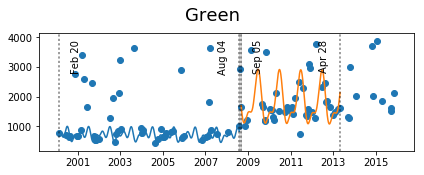

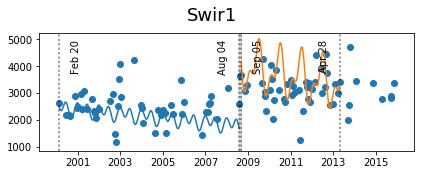

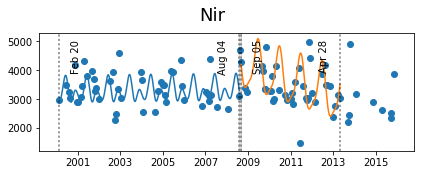

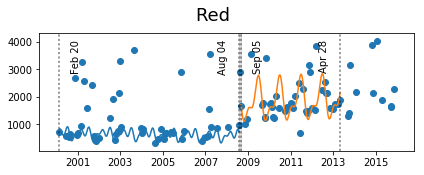

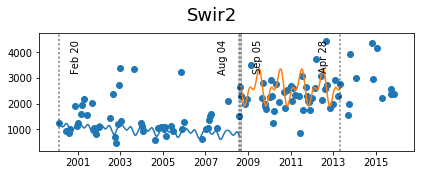

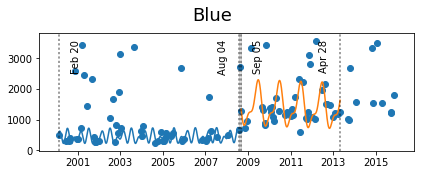

In [23]:
ccd.plot_pixel(processed_pixel)

<br>  

## The  dc_ccd library

The following functions can be called from `dc_ccd`:  

- `dc_ccd.process_pixel(ds)`  
  takes a 1-by-1 dataset, computes ccd, and returns a duplicate pixel with xarray metadata appended.  
  
    
- `dc_ccd.plot_pixel(ds, bands = None)`:  
  takes a 1-by-1 dataset that has been processed by ccd and plots the time series models for that pixel.  
  This function accepts an additional parameter called bands that can be used to limit what is plotted. Simply pass in a list of   band name strings.    
  
    
- `dc_ccd.process_xarray(ds, distributed = True)`: takes a dataset and returns a change_volume product. Accepts an aditional  
   parameter called `distributed` that toggles full core-utilization/distribution of ccd processing.  


`